In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import random
from tqdm import tqdm
import cv2
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from segmentation_

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
TRAIN_PATH = "dataset/2d_slices/model_training_data/train/"
VALIDATION_PATH = "dataset/2d_slices/model_training_data/validation/"
TEST_PATH = "dataset/2d_slices/model_training_data/test/"
TRAIN_MASK_PATH = "dataset/2d_slices/model_training_data/mask_train/"
VALIDATION_MASK_PATH = "dataset/2d_slices/model_training_data/mask_validation/"
TEST_MASK_PATH = "dataset/2d_slices/model_training_data/mask_test/"

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[2]
validation_ids =  next(os.walk(VALIDATION_PATH))[2]
test_ids =  next(os.walk(TEST_PATH))[2]
mask_train_ids = next(os.walk(TRAIN_MASK_PATH))[2]
mask_validation_ids =  next(os.walk(VALIDATION_MASK_PATH))[2]
mask_test_ids =  next(os.walk(TEST_MASK_PATH))[2]

In [5]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

In [6]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train=np.zeros((len(mask_train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype = np.float16)

### Normalizing the image

In [7]:
# We don't need a big range of voxel values(density HU) for lungs. "http://radclass.mudr.org/content/hounsfield-units-scale-hu-ct-numbers"

In [8]:
# We make a bonding on voxel values to be inside [-1200.0, 600.0] and if it was out of the bounding, it would be decreased or increased to be equal to 600 or -1200.
#Then we will scale values to be inside [0.0, 255.0].

In [9]:
def normalize(image):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image2[image2 > 1] = 1.
        image2[image2 < 0] = 0.
        image2 *= 255.
        return image2

In [10]:
print("Resizing and normalizing training images and masks")

Resizing and normalizing training images and masks


In [11]:
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=TRAIN_PATH+id_
    imgs = np.load(TRAIN_PATH+id_)
    img_normal = normalize(imgs)
    img = resize(img_normal,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_train[n]=np.expand_dims(img, axis=2)
    #getting_mask_name
    mask_id_split= id_.split("images")[1]
    mask_id = ("masks"+ mask_id_split)
    #print(mask_id)
    mask = np.load(TRAIN_MASK_PATH+mask_id)
    mask_resize = resize(mask,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    Y_train[n] = np.expand_dims(mask_resize, axis=2)

100%|████████████████████████████████████████████████████████████████████████████████| 427/427 [02:01<00:00,  3.51it/s]


In [12]:
X_validation = np.zeros((len(test_ids),IMG_HEIGHT,IMG_WIDTH),dtype=np.uint8)
Y_validation=np.zeros((len(mask_train_ids),IMG_HEIGHT,IMG_WIDTH),dtype = np.float16)
#sizes_test=[]
print("Resizing and normalizing validation images")

Resizing and normalizing validation images


In [ ]:
# c=0
# for i,j in enumerate(validation_ids):
#     print(i,j)
#     c=c+1
# print(c)


In [ ]:
for n,id_ in tqdm(enumerate(validation_ids),total=len(validation_ids)):
    path=VALIDATION_PATH+id_
    imgs = np.load(VALIDATION_PATH+id_)
    img_normal = normalize(imgs)
    img = resize(img_normal,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_validation[n]=img
#     #getting_mask_name
#     mask_id_split= id_.split("images")[1]
#     mask_id = ("masks"+ mask_id_split)
#     #print(mask_id)
#     mask = np.load(VALIDATION_MASK_PATH+mask_id)
#     mask_resize = resize(mask,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
#     Y_validation[n] = mask_resize

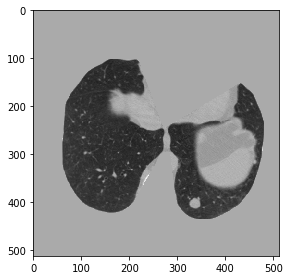

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


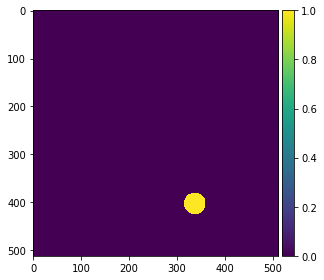

In [13]:
#Checking the training data
ix=random.randint(0,len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()

In [14]:
#https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
def dice_coef(y_true, y_pred, smooth = 100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [14]:
def dice_coef_loss_and_bce(y_true, y_pred):
#     dice_loss = 1- dice_coef(y_true, y_pred) 
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#     term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
#     term_1 = y_true * K.log(y_pred + K.epsilon())
#     bce_loss = -K.mean(term_0 + term_1, axis=0)
#     mean = 0.5*(dice_loss + bce_loss)
    return 1- dice_coef(y_true, y_pred)

In [15]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

In [16]:
s = tf.keras.layers.Lambda(lambda x:x / 255)(inputs)

### Constructing U NET

In [17]:
c1 = tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer = "he_normal",padding="same")(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

In [18]:
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)

In [19]:
c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

In [20]:
c4=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(126,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

In [21]:
c5=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

In [22]:
#expansive path

In [23]:
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)

In [24]:
u7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)

In [25]:
u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c8)


In [26]:
u9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
u9=tf.keras.layers.concatenate([u9,c1],axis=3)
c9=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c9)


In [27]:
outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(c9)

In [28]:
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
model_unet=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model_unet.compile(optimizer="adam",loss=dice_coef_loss_and_bce,metrics=[dice_coef])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 spose)                         )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'conv2d_3[0][0]']               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 256, 256, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
          

In [29]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("model_for_nodule.h5",verbose=1,save_best_only=True)

In [30]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_dice_coef"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

In [31]:
 results = model_unet.fit(X_train,Y_train,validation_split=0.1,batch_size=4,epochs=100,callbacks=callbacks )

Epoch 1/100
96/96 [==============================] - ETA: 0s - loss: 0.9387 - dice_coef: 0.0613
Epoch 1: val_loss improved from inf to 0.92572, saving model to model_for_nodule.h5
96/96 [==============================] - 410s 4s/step - loss: 0.9387 - dice_coef: 0.0613 - val_loss: 0.9257 - val_dice_coef: 0.0731
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 0.9317 - dice_coef: 0.0683
Epoch 2: val_loss did not improve from 0.92572
96/96 [==============================] - 456s 5s/step - loss: 0.9317 - dice_coef: 0.0683 - val_loss: 0.9257 - val_dice_coef: 0.0731
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 0.9334 - dice_coef: 0.0666
Epoch 3: val_loss did not improve from 0.92572
96/96 [==============================] - 463s 5s/step - loss: 0.9334 - dice_coef: 0.0666 - val_loss: 0.9257 - val_dice_coef: 0.0731
Epoch 4/100
96/96 [==============================] - ETA: 0s - loss: 0.9290 - dice_coef: 0.0710
Epoch 4: val_loss did not improve from 0.9

#### Checking the model on random images

In [32]:
idx = random.randint(0,len(X_train))

In [33]:
preds_train = model_unet.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model_unet.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
#preds_test=model_unet.predict(X_t,verbose=1)

2/2 [==============================] - 13s 3s/step


In [ ]:
#Each pixel is given a value between 0 and 1. We set a threshold 0.5 to binarize using thresholding

In [ ]:
preds_train_t = (preds_train >0.6).astype(np.uint8)
preds_val_t = (preds_val>0.6).astype(np.uint8)
#preds_test_t = (preds_test>0.6).astype(np.uint8)

In [ ]:
#Checking

In [ ]:
ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()
imshow(preds_train_t[ix])
plt.show()